# Deepfake Image Classification with PyTorch

This notebook demonstrates a full workflow for classifying deepfake images using a convolutional neural network (CNN) in PyTorch. The steps include data exploration, preprocessing, model building, training, and evaluation, with visualizations and clear explanations throughout.


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from pathlib import Path
import os
from sklearn.metrics import roc_auc_score

## Preprocessing


### Visualize a Sample Image
Display a sample image from the dataset to verify image loading and format.

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Display a sample image to verify loading
def show_image(image_path):
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

show_image("FF++/Fake/000_003/001_0.tiff")


### Explore Dataset Structure

In [ ]:
from pathlib import Path
def explore_dataset(root_dir):
    root = Path(root_dir)
    for category in root.iterdir():
        print(f"[{category.name}]")
        for person_folder in category.iterdir():
            print(f"  - {person_folder.name}: {len(list(person_folder.glob('*.tiff')))} images")
explore_dataset("FF++")


### Prepare the Dataset List
Create a list of image file paths and their corresponding labels for training and evaluation.

In [3]:
from pathlib import Path

image_label_list = []

def prepare_dataset_list(root_dir):
    root = Path(root_dir)
    for label_str, label_num in [('Real', 0), ('Fake', 1)]:
        label_path = root / label_str
        if not label_path.exists():
            continue
        for person_folder in label_path.iterdir():
            if person_folder.is_dir():
                for image_path in person_folder.glob('*.tiff'):
                    image_label_list.append((str(image_path), label_num))
    return image_label_list
dataset_list = prepare_dataset_list("FF++")
print("Sampled Dataset Size:", len(dataset_list))
print("Sample:", dataset_list[:5])


Sampled Dataset Size: 24000
Sample: [('FF++\\Real\\000\\000_0.tiff', 0), ('FF++\\Real\\000\\001_0.tiff', 0), ('FF++\\Real\\000\\002_0.tiff', 0), ('FF++\\Real\\000\\003_0.tiff', 0), ('FF++\\Real\\000\\004_0.tiff', 0)]


note : we could've used the `load_dataset` from `datasets` but each dataset would be {'image': {'path': '/path/to/image.jpg', 'bytes': None}, 'label': 1} which is very long 

### Print Folder Names and Image Counts

This section demonstrates how to display the names of the folders and the number of images sampled from each folder to verify data sampling.

In [ ]:
def print_folder_image_counts(root_dir):
    sumImages = 0
    root = Path(root_dir)
    for label_str, label_num in [('real', 0), ('fake', 1)]:
        label_path = root / label_str
        if not label_path.exists():
            continue
        print(f"Category: {label_str}")
        dirs = sorted(label_path.iterdir())
        for person_folder in dirs:
            if person_folder.is_dir():
                image_count = len(list(person_folder.glob('*.tiff')))
                sumImages+=image_count
                print(f"Folder: {person_folder.name}, Images Taken: {image_count}")
    print(f'the total images in the {root_dir} directory is : {sumImages}')
print_folder_image_counts("FF++")

### Implement a Basic Data Loader
Convert image files to tensors and prepare them for model input using PyTorch utilities.

In [ ]:
# import torch
# from torch.utils.data import Dataset, DataLoader
# from PIL import Image
# from torchvision import transforms

# # Step 1: Define a transform (resize, tensor, normalize)
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize([0.5]*3, [0.5]*3)
# ])

# # Step 2: Prepare your dataset list
# def prepare_dataset(data_list, transform):
#     images = []
#     labels = []

#     for path, label in data_list:
#         print(f"Loading: {path}")  # Debug print
#         img = Image.open(path).convert('RGB')
#         img = transform(img)
#         print(f"Transformed shape: {img.shape}, dtype: {img.dtype}")  # Debug info
#         images.append(img)
#         labels.append(label)

#     return torch.stack(images), torch.tensor(labels)

# # Step 3: Example usage
# image_tensors, label_tensors = prepare_dataset(dataset_list, transform)
# print(image_tensors)

# # Now you can create a TensorDataset and DataLoader
# # from torch.utils.data import TensorDataset, DataLoader

# dataset = TensorDataset(image_tensors, label_tensors)
# loader = DataLoader(dataset, batch_size=16, shuffle=True)


### Implement Lazy Loading for Efficient Memory Usage

Use PyTorch's `Dataset` class to load images on-the-fly during training or evaluation, reducing memory usage. This approach avoids loading all images into memory at once.

In [4]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

class LazyDataset(Dataset):
    def __init__(self, data_list, transform):
        self.data_list = data_list
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        path, label = self.data_list[idx]
        img = Image.open(path).convert('RGB')
        img = self.transform(img)
        return img, label

# Example usage
lazy_dataset = LazyDataset(dataset_list, transform)
# loader = DataLoader(lazy_dataset, batch_size=16, shuffle=True) for testing only

# Iterate through the DataLoader
# for images, labels in loader:
#     print(f"Batch size: {images.size(0)}, Image shape: {images.shape}, Labels: {labels}")

In [5]:
from torch.utils.data import random_split, DataLoader

# Train/test split and DataLoader creation
train_ratio = 0.8
# the test ratio will be automatically 0.2

# Calculate the sizes for training and testing sets
total_size = len(lazy_dataset)
train_size = int(total_size * train_ratio)
test_size = total_size - train_size

# Split the dataset
train_dataset, test_dataset = random_split(lazy_dataset, [train_size, test_size])

# Create DataLoaders for training and testing
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)    

# Example usage
for images, labels in train_loader:
    print(f"Training batch - Images: {images.shape}, Labels: {labels}")

for images, labels in test_loader:
    print(f"Testing batch - Images: {images.shape}, Labels: {labels}")

Training batch - Images: torch.Size([16, 3, 224, 224]), Labels: tensor([1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1])
Training batch - Images: torch.Size([16, 3, 224, 224]), Labels: tensor([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1])
Training batch - Images: torch.Size([16, 3, 224, 224]), Labels: tensor([0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1])
Training batch - Images: torch.Size([16, 3, 224, 224]), Labels: tensor([1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1])
Training batch - Images: torch.Size([16, 3, 224, 224]), Labels: tensor([1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0])
Training batch - Images: torch.Size([16, 3, 224, 224]), Labels: tensor([1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0])
Training batch - Images: torch.Size([16, 3, 224, 224]), Labels: tensor([0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1])
Training batch - Images: torch.Size([16, 3, 224, 224]), Labels: tensor([1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1])
Training batch - Images: torch.S

### Visualize a Batch of Images
Display a batch of images from the DataLoader to verify preprocessing and data augmentation steps.

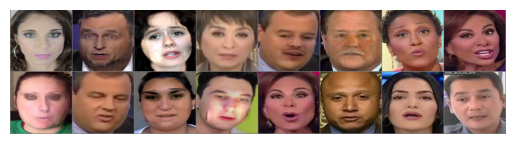

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torchvision.utils import make_grid

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(make_grid(images))

## Training With a simple CNN Model

### Define the CNN Model
Build a basic convolutional neural network (CNN) architecture for image classification using PyTorch.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)  ## only 2 outputs in here since it's between real and fake 

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### Training Loop and Visualization
Run the training loop and visualize loss and AUC metrics for each epoch and batch.

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

#### Training for Multiple Epochs
Iterate over the dataset for several epochs to optimize the model.

In [ ]:
# from sklearn.metrics import roc_auc_score
# epoch_aucs = []
# epoch_losses = []
# for epoch in range(2):
#     running_loss = 0.0
#     correct_train = 0
#     total_train = 0
#     all_scores = []
#     all_labels = []
#     epoch_loss_sum = 0.0
#     for i, data in enumerate(train_loader, 0):
#         inputs, labels = data
#         optimizer.zero_grad()
#         outputs = net(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         _, pred_cls = torch.max(outputs, 1)
#         correct_train += (pred_cls == labels).sum().item()
#         total_train += labels.size(0)
#         all_scores.append(outputs[:, 1].detach().cpu())
#         all_labels.append(labels.detach().cpu())
#         epoch_loss_sum += loss.item()
#         running_loss += loss.item()
#         if i % 200 == 199:
#             print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
#             running_loss = 0.0
#     accuracy = 100 * correct_train / total_train
#     all_scores = torch.cat(all_scores)
#     all_labels = torch.cat(all_labels)
#     auc = roc_auc_score(all_labels.numpy(), all_scores.numpy())
#     epoch_aucs.append(auc)
#     epoch_losses.append(epoch_loss_sum / len(train_loader))
#     print(f'Epoch {epoch + 1} - Accuracy: {accuracy:.2f}%, AUC: {auc:.4f}, Loss: {epoch_loss_sum:.4f}')
# print('Finished Training')
# torch.save(net.state_dict(), "fake_image_model.pth")


In [ ]:
# import matplotlib.pyplot as plt

# # Plot Epoch Loss and AUC
# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
# plt.plot(epoch_losses, marker='o')
# plt.title('Loss per Epoch')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.subplot(1, 2, 2)
# plt.plot(epoch_aucs, marker='o', color='green')
# plt.title('AUC per Epoch')
# plt.xlabel('Epoch')
# plt.ylabel('AUC')
# plt.tight_layout()
# plt.show()


#### Batch-Level Training Statistics
Monitor and log loss, accuracy, and AUC for every batch during training.

In [ ]:
from sklearn.metrics import roc_auc_score

epoch_aucs = []  # AUCs per epoch
epoch_losses = []  # Losses per epoch
batch_losses = []
batch_accuracies = []
batch_auc_scores = []
log_steps = 200  # Every 200 batches

for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    all_scores = []
    all_labels = []

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # predictions and accuracy
        _, pred_cls = torch.max(outputs, 1)
        correct_train += (pred_cls == labels).sum().item()
        total_train += labels.size(0)

        all_scores.append(outputs[:, 1].detach().cpu())  
        all_labels.append(labels.detach().cpu())

        # Add running loss
        running_loss += loss.item()


        # Every 200 batches we save the loss / accuracy / ACU
        if i % log_steps == log_steps - 1:
            avg_loss = running_loss / log_steps
            batch_losses.append(avg_loss)  # Save instead of per-batch loss
            current_accuracy = 100 * correct_train / total_train
            batch_accuracies.append(current_accuracy)
            partial_scores = torch.cat(all_scores)
            partial_labels = torch.cat(all_labels)
            partial_auc = roc_auc_score(partial_labels.numpy(), partial_scores.numpy())

            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / log_steps:.3f}, accuracy: {current_accuracy:.2f}%, AUC: {partial_auc:.4f}')

            # Save stats every 200 batches
            batch_auc_scores.append(partial_auc)

            # Reset for next 200 batches
            running_loss = 0.0
            correct_train = 0
            total_train = 0
            all_scores = []
            all_labels = []

    # Epoch-level stats
    print(f'Epoch {epoch + 1} done.\n')

print('Finished Training')
torch.save(net.state_dict(), "fake_image_model.pth")



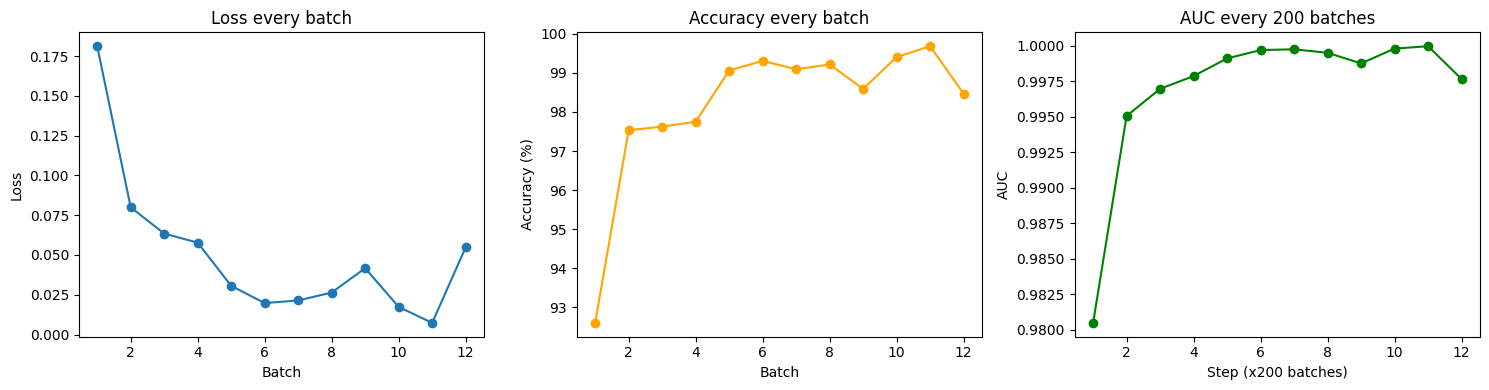

In [7]:
import matplotlib.pyplot as plt

# For batch_losses and batch_accuracies (per batch)
steps_batches = list(range(1, len(batch_losses) + 1))

# For batch_auc_scores (every 200 batches)
steps_200_batches = list(range(1, len(batch_auc_scores) + 1))

plt.figure(figsize=(15, 4))

# Loss every batch
plt.subplot(1, 3, 1)
plt.plot(steps_batches, batch_losses, marker='o')
plt.title('Loss every batch')
plt.xlabel('Batch')
plt.ylabel('Loss')

# Accuracy every batch
plt.subplot(1, 3, 2)
plt.plot(steps_batches, batch_accuracies, marker='o', color='orange')
plt.title('Accuracy every batch')
plt.xlabel('Batch')
plt.ylabel('Accuracy (%)')

# AUC every 200 batches
plt.subplot(1, 3, 3)
plt.plot(steps_200_batches, batch_auc_scores, marker='o', color='green')
plt.title('AUC every 200 batches')
plt.xlabel('Step (x200 batches)')
plt.ylabel('AUC')

plt.tight_layout()
plt.show()


### Testing and Visualization
Evaluate the trained model on the test set and visualize the results.

#### Test Metrics per Epoch
Track and visualize loss and AUC for each test epoch.

In [ ]:
# # Testing loop
# test_aucs = []  # Initialize list to store AUC values
# test_losses = []  # Initialize list to store loss values

# with torch.no_grad():  # Disable gradient computation for testing
#     running_loss = 0.0
#     correct_test = 0
#     total_test = 0
#     all_scores = []
#     all_labels = []

#     for i, data in enumerate(test_loader, 0):
#         inputs, labels = data
#         outputs = net(inputs)
#         loss = criterion(outputs, labels)
#         _, pred_cls = torch.max(outputs, 1)
#         correct_test += (pred_cls == labels).sum().item()
#         total_test += labels.size(0)
#         all_scores.append(outputs[:, 1].detach().cpu())  # Assuming binary classification
#         all_labels.append(labels.detach().cpu())

#         running_loss += loss.item()
    
    
#     accuracy = 100 * correct_test / total_test
#     all_scores = torch.cat(all_scores)
#     all_labels = torch.cat(all_labels)
#     auc = roc_auc_score(all_labels.numpy(), all_scores.numpy())
#     test_aucs.append(auc)  # Save AUC for testing
#     test_losses.append(running_loss)  # Save total loss for testing
#     print(f'Test - Accuracy: {accuracy:.2f}%, AUC: {auc:.4f}, Loss: {running_loss:.4f}')



In [ ]:
# # Plot Loss and AUC
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.plot(range(1, len(test_losses) + 1), test_losses, marker='o', label='Loss')
# plt.title('Test Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.subplot(1, 2, 2)
# plt.plot(range(1, len(test_aucs) + 1), test_aucs, marker='o', label='AUC')
# plt.title('Test AUC')
# plt.xlabel('Epoch')
# plt.ylabel('AUC')
# plt.legend()
# plt.tight_layout()
# plt.show()

#### Test Metrics per mini-batches

In [ ]:
log_steps = 5  # or any number 

test_losses = []
test_accuracies = []
test_auc_scores = []

running_loss = 0.0
correct_test = 0
total_test = 0
all_scores = []
all_labels = []

with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        inputs, labels = data
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        _, pred_cls = torch.max(outputs, 1)
        correct_test += (pred_cls == labels).sum().item()
        total_test += labels.size(0)

        all_scores.append(outputs[:, 1].detach().cpu())
        all_labels.append(labels.detach().cpu())

        running_loss += loss.item()

        # Every log_steps batches, calculate and save metrics
        if (i + 1) % log_steps == 0:
            current_accuracy = 100 * correct_test / total_test
            partial_scores = torch.cat(all_scores)
            partial_labels = torch.cat(all_labels)
            partial_auc = roc_auc_score(partial_labels.numpy(), partial_scores.numpy())

            avg_loss = running_loss / log_steps

            test_losses.append(avg_loss)
            test_accuracies.append(current_accuracy)
            test_auc_scores.append(partial_auc)

            # Print statistics
            print(f'Test batches [{i+1-log_steps+1}–{i+1}]: Loss: {avg_loss:.4f}, Accuracy: {current_accuracy:.2f}%, AUC: {partial_auc:.4f}')

            # Reset for next interval
            running_loss = 0.0
            correct_test = 0
            total_test = 0
            all_scores = []
            all_labels = []

print('Finished Testing')


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Log Interval')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Log Interval')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(test_auc_scores, label='Test AUC')
plt.xlabel('Log Interval')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import gradio as gr
# Load model
net = Net()
net.load_state_dict(torch.load("fake_image_model.pth", map_location="cpu"))

net.eval()


# Define transform and predict function
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Optional but often helpful
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

def predict(img):
    img_tensor = transform(img).unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        outputs = net(img_tensor)
        probabilities = torch.softmax(outputs, dim=1)[0]  # Get first sample's output

    fake_prob = probabilities[1].item()  # Assuming class index 1 = "Fake"
    real_prob = probabilities[0].item()
    return {"Fake": fake_prob, "Real": real_prob}


# Gradio Interface
demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(num_top_classes=2),
    title="Fake Image Detector",
    description="Upload an image to detect if it's fake or real."
)

demo.launch()

## Training with a vgg model

In [4]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score



# 3. Load VGG16 and modify it
vgg16_model = torchvision.models.vgg16(weights=None)
vgg16_model.classifier[6] = nn.Linear(4096, 1)

# 4. Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16_model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(vgg16_model.parameters(), lr=1e-4)



from pathlib import Path

image_label_list = []

def prepare_dataset_list(root_dir):
    root = Path(root_dir)
    for label_str, label_num in [('Real', 0), ('Fake', 1)]:
        label_path = root / label_str
        if not label_path.exists():
            continue
        for person_folder in label_path.iterdir():
            if person_folder.is_dir():
                for image_path in person_folder.glob('*.tiff'):
                    image_label_list.append((str(image_path), label_num))
    return image_label_list
dataset_list = prepare_dataset_list("FF++")
print("Sampled Dataset Size:", len(dataset_list))
print("Sample:", dataset_list[:5])


from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

class LazyDataset(Dataset):
    def __init__(self, data_list, transform):
        self.data_list = data_list
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        path, label = self.data_list[idx]
        img = Image.open(path).convert('RGB')
        img = self.transform(img)
        return img, label

# Example usage
lazy_dataset = LazyDataset(dataset_list, transform)
# loader = DataLoader(lazy_dataset, batch_size=16, shuffle=True) for testing only

# Iterate through the DataLoader
# for images, labels in loader:
#     print(f"Batch size: {images.size(0)}, Image shape: {images.shape}, Labels: {labels}")


from torch.utils.data import random_split, DataLoader

# Train/test split and DataLoader creation
train_ratio = 0.8
# the test ratio will be automatically 0.2

# Calculate the sizes for training and testing sets
total_size = len(lazy_dataset)
train_size = int(total_size * train_ratio)
test_size = total_size - train_size

# Split the dataset
train_dataset, test_dataset = random_split(lazy_dataset, [train_size, test_size])

# Create DataLoaders for training and testing
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)    

# Example usage
for images, labels in train_loader:
    print(f"Training batch - Images: {images.shape}, Labels: {labels}")

for images, labels in test_loader:
    print(f"Testing batch - Images: {images.shape}, Labels: {labels}")

Sampled Dataset Size: 24000
Sample: [('FF++\\Real\\000\\000_0.tiff', 0), ('FF++\\Real\\000\\001_0.tiff', 0), ('FF++\\Real\\000\\002_0.tiff', 0), ('FF++\\Real\\000\\003_0.tiff', 0), ('FF++\\Real\\000\\004_0.tiff', 0)]
Training batch - Images: torch.Size([16, 3, 224, 224]), Labels: tensor([1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0])
Training batch - Images: torch.Size([16, 3, 224, 224]), Labels: tensor([1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1])
Training batch - Images: torch.Size([16, 3, 224, 224]), Labels: tensor([1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1])
Training batch - Images: torch.Size([16, 3, 224, 224]), Labels: tensor([1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1])
Training batch - Images: torch.Size([16, 3, 224, 224]), Labels: tensor([0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1])
Training batch - Images: torch.Size([16, 3, 224, 224]), Labels: tensor([0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1])
Training batch - Images: torch.Size([16, 3, 224, 224]), L

In [6]:
import torchvision.models as models
import torch.nn as nn

# Load MobileNetV2 with pretrained weights
mobilenet = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)

# Replace final layer for binary classification (1 output)
mobilenet.classifier[1] = nn.Linear(mobilenet.classifier[1].in_features, 1)

# Send to device
mobilenet = mobilenet.to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(mobilenet.parameters(), lr=0.001)

# Training loop
mobilenet.train()

epoch_aucs = []  # AUCs per epoch
epoch_losses = []  # Losses per epoch
batch_losses = []
batch_accuracies = []
batch_auc_scores = []
log_steps = 200  # Every 200 batches

for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    all_scores = []
    all_labels = []

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.float().unsqueeze(1).to(device)  # Shape: [batch_size, 1]

        optimizer.zero_grad()
        outputs = mobilenet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # predictions and accuracy
        pred_cls = (torch.sigmoid(outputs) > 0.5).float()
        correct_train += (pred_cls == labels).sum().item()
        total_train += labels.size(0)

        all_scores.append(outputs.detach().cpu().squeeze())  
        all_labels.append(labels.detach().cpu())

        # Add running loss
        running_loss += loss.item()

        # Every 200 batches we save the loss / accuracy / AUC
        if i % log_steps == log_steps - 1:
            avg_loss = running_loss / log_steps
            batch_losses.append(avg_loss)
            current_accuracy = 100 * correct_train / total_train
            batch_accuracies.append(current_accuracy)
            partial_scores = torch.cat(all_scores)
            partial_labels = torch.cat(all_labels)
            partial_auc = roc_auc_score(partial_labels.numpy(), partial_scores.numpy())

            print(f'[{epoch + 1}, {i + 1:5d}] loss: {avg_loss:.3f}, accuracy: {current_accuracy:.2f}%, AUC: {partial_auc:.4f}')

            batch_auc_scores.append(partial_auc)

            # Reset stats
            running_loss = 0.0
            correct_train = 0
            total_train = 0
            all_scores = []
            all_labels = []

    print(f'Epoch {epoch + 1} done.\n')

print('Finished Training')
torch.save(mobilenet.state_dict(), "fake_image_model_mobilenet.pth")


Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to C:\Users\job/.cache\torch\hub\checkpoints\mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:04<00:00, 3.49MB/s]


[1,   200] loss: 0.181, accuracy: 92.59%, AUC: 0.9805
[1,   400] loss: 0.080, accuracy: 97.53%, AUC: 0.9951
[1,   600] loss: 0.063, accuracy: 97.62%, AUC: 0.9970
[1,   800] loss: 0.058, accuracy: 97.75%, AUC: 0.9979
[1,  1000] loss: 0.031, accuracy: 99.06%, AUC: 0.9991
[1,  1200] loss: 0.020, accuracy: 99.31%, AUC: 0.9997
Epoch 1 done.

[2,   200] loss: 0.021, accuracy: 99.09%, AUC: 0.9997
[2,   400] loss: 0.026, accuracy: 99.22%, AUC: 0.9995
[2,   600] loss: 0.042, accuracy: 98.59%, AUC: 0.9988
[2,   800] loss: 0.017, accuracy: 99.41%, AUC: 0.9998
[2,  1000] loss: 0.007, accuracy: 99.69%, AUC: 1.0000
[2,  1200] loss: 0.055, accuracy: 98.47%, AUC: 0.9977
Epoch 2 done.

Finished Training
